In [1]:
import sys
sys.path.append('../')
from src import load_dataset

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import FrenchStemmer
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/charles/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
X, y = load_dataset()
X_valid, y_valid = load_dataset("../data/raw/corpus.tache1.test.utf8")

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score, roc_auc_score

def print_score(y_test, pred, name):
    reports = f"""
    Macro F1-score : {f1_score(y_test, pred, average='macro')}
    Micro F1-score : {f1_score(y_test, pred, average='micro')}
    Macro ROC-AUC: {roc_auc_score(y_test, pred)}
    Weighted ROC-AUC: {roc_auc_score(y_test, pred, average="weighted")}
    Classification report :
    {classification_report(y_test, pred)}
    """
    print(name, ':')
    print(reports)

def eval(X_train, y_train, X_test, y_test, balanced=None):
    #Naïve Bayes
    if balanced==None:
        nb_clf = MultinomialNB()
    else:
        balanced = "balanced"
        nb_clf = MultinomialNB(fit_prior=True)
    nb_clf.fit(X_train, y_train)

    #Logistic Regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1, max_iter=10000, class_weight=balanced)
    lr_clf.fit(X_train, y_train)

    #Linear SVM
    svm_clf = LinearSVC(random_state=0, tol=1e-5, max_iter=10000, class_weight=balanced)
    svm_clf.fit(X_train, y_train)

    pred_nb = nb_clf.predict(X_test)
    pred_lr = lr_clf.predict(X_test)
    pred_svm = svm_clf.predict(X_test)

    print_score(y_test, pred_nb, 'Naïve Bayes')
    print_score(y_test, pred_lr, 'Logistic Regression')
    print_score(y_test, pred_svm, 'SVM')

In [4]:
stemmer = FrenchStemmer()
stopwords_list = stopwords.words('french')[:66] #on cut avant les différentes formes du verbe être/avoir qui seront handle par le stemmer


class Mixed_analyzer():
    def __init__(self, baseVectorizer=CountVectorizer(), stemmer=None) -> None:
        """
        :param baseVectorizer : un vectorizer de Sklearn déjà custom sans analyser
        :param stemmer : un stemmer si besoin
        """
        self.preprocess = baseVectorizer.build_preprocessor()
        self.tokenizer = baseVectorizer.build_tokenizer()
        self.analyzer = baseVectorizer.build_analyzer()

        self.stemmer = stemmer

    def __call__(self, doc):
        """
        Stem avec nltk + regarde les stopwords
        """
        # Preprocessing : 
        #   Takes an entire document as input (as a single string), and returns a possibly transformed version of the document, still as an entire string. 
        #   This can be used to remove HTML tags, lowercase the entire document, etc.
        # preprocess_doc = preprocess(doc)
    
        # Tokenizer :
        #   a callable that takes the output from the preprocessor 
        #   and splits it into tokens, then returns a list of these.
        
        # N-gram extraction and stop word filtering take place at the analyzer level
        
        # Ici il preprocess + tokenise à partir du baseVectorizer
        # * strip accent
        # * Stop word
        tokenized_list = self.analyzer(doc)
    
        # Stemming
        if self.stemmer != None:
            return [stemmer.stem(w) for w in tokenized_list]
        return tokenized_list
    
        # return tokenized_list

In [5]:
mixed_analyzer = Mixed_analyzer(CountVectorizer(
    strip_accents="ascii",
    stop_words=stopwords_list,
), FrenchStemmer())

vectorizer = CountVectorizer(
    analyzer=mixed_analyzer,
    )
X_transformed = vectorizer.fit_transform(X)
X_valid = vectorizer.transform(X_valid)

/home/charles/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['meme'] not in stop_words.
  warnings.warn(


In [6]:
words = vectorizer.get_feature_names_out()
words[400:500]

array(['absenc', 'absent', 'absente', 'absolu', 'absolus', 'absolut',
       'absorb', 'absorpt', 'absten', 'abstent', 'abstention', 'abstenu',
       'abstract', 'abstrair', 'abstrait', 'absurd', 'absurdit', 'abuj',
       'abus', 'abym', 'acad', 'academ', 'academicien', 'acadien',
       'acapulco', 'accabl', 'accablent', 'accapar', 'acce', 'acced',
       'accedent', 'accederent', 'accel', 'acceler', 'accelere',
       'accelerent', 'accent', 'accentu', 'accentue', 'accentuent',
       'accept', 'accepte', 'acceptent', 'accepton', 'access',
       'accessibilit', 'accessibl', 'accessoir', 'accident', 'accidentel',
       'acclam', 'acclimat', 'accol', 'accommod', 'accommodent',
       'accomod', 'accompagn', 'accompagne', 'accompagnent',
       'accompagnon', 'accompl', 'accord', 'accorde', 'accordent',
       'accordon', 'accost', 'accouch', 'accourt', 'accredit', 'accroch',
       'accrochag', 'accroche', 'accroiss', 'accroissement',
       'accroissent', 'accroit', 'accroitr', 'a

# Prediction

<AxesSubplot:ylabel='None'>

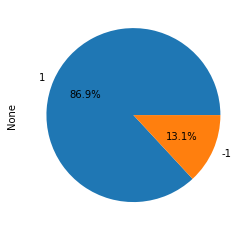

In [7]:
# plt.plot(y, kind=pie)
pd.Series(y).value_counts().plot.pie(autopct='%1.1f%%')

Un des deux ne parle pas beaucoup. Il vas falloir équilibrer les classes

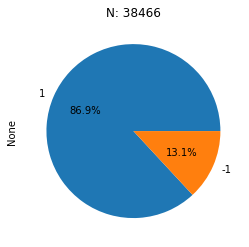

<AxesSubplot:title={'center':'N: 18947'}, ylabel='None'>

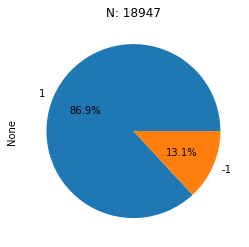

In [8]:
from sklearn.model_selection import train_test_split

# with a seed to enhence reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.33, random_state=0, stratify=y)
pd.Series(y_train).value_counts().plot.pie(autopct='%1.1f%%', title=f'N: {len(y_train)}')
plt.show()
pd.Series(y_test).value_counts().plot.pie(autopct='%1.1f%%', title=f'N: {len(y_test)}')

In [9]:
eval(X_train, y_train, X_test, y_test)

Naïve Bayes :

    Macro F1-score : 0.7177409085981219
    Micro F1-score : 0.884308861561197
    Macro ROC-AUC: 0.6969374863747927
    Weighted ROC-AUC: 0.6969374863747927
    Classification report :
                  precision    recall  f1-score   support

          -1       0.58      0.44      0.50      2483
           1       0.92      0.95      0.93     16464

    accuracy                           0.88     18947
   macro avg       0.75      0.70      0.72     18947
weighted avg       0.87      0.88      0.88     18947

    
Logistic Regression :

    Macro F1-score : 0.7122868489336515
    Micro F1-score : 0.8956563044281417
    Macro ROC-AUC: 0.6730288801557099
    Weighted ROC-AUC: 0.6730288801557099
    Classification report :
                  precision    recall  f1-score   support

          -1       0.69      0.37      0.48      2483
           1       0.91      0.97      0.94     16464

    accuracy                           0.90     18947
   macro avg       0.80      0.

In [10]:
eval(X_train, y_train, X_valid, y_valid)

Naïve Bayes :

    Macro F1-score : 0.49462710216428396
    Micro F1-score : 0.7808703335542302
    Macro ROC-AUC: 0.49530682407631166
    Weighted ROC-AUC: 0.49530682407631166
    Classification report :
                  precision    recall  f1-score   support

          -1       0.10      0.13      0.11      2918
           1       0.89      0.86      0.87     24244

    accuracy                           0.78     27162
   macro avg       0.50      0.50      0.49     27162
weighted avg       0.81      0.78      0.79     27162

    
Logistic Regression :

    Macro F1-score : 0.5027613711397979
    Micro F1-score : 0.8330388042117665
    Macro ROC-AUC: 0.503579554854637
    Weighted ROC-AUC: 0.503579554854637
    Classification report :
                  precision    recall  f1-score   support

          -1       0.12      0.08      0.10      2918
           1       0.89      0.92      0.91     24244

    accuracy                           0.83     27162
   macro avg       0.50      

## Oversampler

Utilisons un [Random over sampler](https://imbalanced-learn.org/stable/over_sampling.html#random-over-sampler)

In [11]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ROS_train, y_ROS_train = ros.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=42)
X_ROS_test, y_ROS_test = ros.fit_resample(X_test, y_test)

"Nombre d'exemple avant over sampling: 38466, après oversampling : 66852"

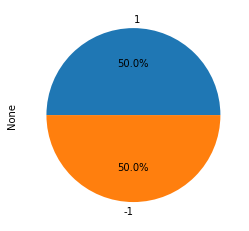

In [12]:
pd.Series(y_ROS_train).value_counts().plot.pie(autopct='%1.1f%%')
f"Nombre d'exemple avant over sampling: {len(y_train)}, après oversampling : {len(y_ROS_train)}"

In [13]:
eval(X_ROS_train, y_ROS_train, X_test, y_test)

Naïve Bayes :

    Macro F1-score : 0.6926593791808493
    Micro F1-score : 0.8073045864780704
    Macro ROC-AUC: 0.782930707234853
    Weighted ROC-AUC: 0.782930707234853
    Classification report :
                  precision    recall  f1-score   support

          -1       0.38      0.75      0.50      2483
           1       0.96      0.82      0.88     16464

    accuracy                           0.81     18947
   macro avg       0.67      0.78      0.69     18947
weighted avg       0.88      0.81      0.83     18947

    
Logistic Regression :

    Macro F1-score : 0.7043141763425462
    Micro F1-score : 0.8303689238401858
    Macro ROC-AUC: 0.7652510834608279
    Weighted ROC-AUC: 0.7652510834608279
    Classification report :
                  precision    recall  f1-score   support

          -1       0.41      0.68      0.51      2483
           1       0.95      0.85      0.90     16464

    accuracy                           0.83     18947
   macro avg       0.68      0.7

In [14]:
eval(X_ROS_train, y_ROS_train, X_ROS_test, y_ROS_test)

Naïve Bayes :

    Macro F1-score : 0.778947626263373
    Micro F1-score : 0.7792456268221575
    Macro ROC-AUC: 0.7792456268221575
    Weighted ROC-AUC: 0.7792456268221575
    Classification report :
                  precision    recall  f1-score   support

          -1       0.80      0.74      0.77     16464
           1       0.76      0.82      0.79     16464

    accuracy                           0.78     32928
   macro avg       0.78      0.78      0.78     32928
weighted avg       0.78      0.78      0.78     32928

    
Logistic Regression :

    Macro F1-score : 0.7605296869839238
    Micro F1-score : 0.7625121477162293
    Macro ROC-AUC: 0.7625121477162293
    Weighted ROC-AUC: 0.7625121477162293
    Classification report :
                  precision    recall  f1-score   support

          -1       0.82      0.67      0.74     16464
           1       0.72      0.85      0.78     16464

    accuracy                           0.76     32928
   macro avg       0.77      0.

In [15]:
ros = RandomOverSampler(random_state=42)
X_ROS_valid, y_ROS_valid = ros.fit_resample(X_valid, y_valid)

In [16]:
eval(X_ROS_train, y_ROS_train, X_valid, y_valid)

Naïve Bayes :

    Macro F1-score : 0.46354489479828814
    Micro F1-score : 0.6700169354244901
    Macro ROC-AUC: 0.47691969376000165
    Weighted ROC-AUC: 0.47691969376000165
    Classification report :
                  precision    recall  f1-score   support

          -1       0.09      0.23      0.13      2918
           1       0.89      0.72      0.80     24244

    accuracy                           0.67     27162
   macro avg       0.49      0.48      0.46     27162
weighted avg       0.80      0.67      0.72     27162

    
Logistic Regression :

    Macro F1-score : 0.4802386866171468
    Micro F1-score : 0.7052867977321258
    Macro ROC-AUC: 0.4918539089510244
    Weighted ROC-AUC: 0.4918539089510244
    Classification report :
                  precision    recall  f1-score   support

          -1       0.10      0.22      0.14      2918
           1       0.89      0.76      0.82     24244

    accuracy                           0.71     27162
   macro avg       0.50    

In [17]:
eval(X_ROS_train, y_ROS_train, X_ROS_valid, y_ROS_valid)

Naïve Bayes :

    Macro F1-score : 0.4463996229272802
    Micro F1-score : 0.4792525985810922
    Macro ROC-AUC: 0.47925259858109226
    Weighted ROC-AUC: 0.47925259858109226
    Classification report :
                  precision    recall  f1-score   support

          -1       0.46      0.24      0.31     24244
           1       0.49      0.72      0.58     24244

    accuracy                           0.48     48488
   macro avg       0.47      0.48      0.45     48488
weighted avg       0.47      0.48      0.45     48488

    
Logistic Regression :

    Macro F1-score : 0.4539616150035324
    Micro F1-score : 0.4937510311829731
    Macro ROC-AUC: 0.4937510311829731
    Weighted ROC-AUC: 0.4937510311829731
    Classification report :
                  precision    recall  f1-score   support

          -1       0.49      0.22      0.31     24244
           1       0.50      0.76      0.60     24244

    accuracy                           0.49     48488
   macro avg       0.49     

<AxesSubplot:ylabel='None'>

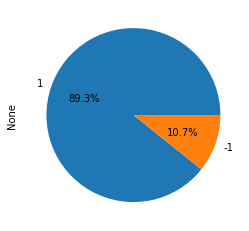

In [18]:
pd.Series(y_valid).value_counts().plot.pie(autopct='%1.1f%%')

In [19]:
# write_classif_report(y_test, pred_lr, name="Lr_Accent_NltkStopword_NltkStemmer")

## Undersampling

In [20]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_RUS_train, y_RUS_train = rus.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=42)
X_RUS_test, y_RUS_test = rus.fit_resample(X_test, y_test)

rus = RandomUnderSampler(random_state=42)
X_RUS_valid, y_RUS_valid = rus.fit_resample(X_valid, y_valid)

In [21]:
eval(X_RUS_train, y_RUS_train, X_test, y_test)

Naïve Bayes :

    Macro F1-score : 0.6405915426575711
    Micro F1-score : 0.7394310444925318
    Macro ROC-AUC: 0.7738008031876233
    Weighted ROC-AUC: 0.7738008031876233
    Classification report :
                  precision    recall  f1-score   support

          -1       0.31      0.82      0.45      2483
           1       0.96      0.73      0.83     16464

    accuracy                           0.74     18947
   macro avg       0.64      0.77      0.64     18947
weighted avg       0.88      0.74      0.78     18947

    
Logistic Regression :

    Macro F1-score : 0.6521028757497664
    Micro F1-score : 0.7608064601256136
    Macro ROC-AUC: 0.7647253632768913
    Weighted ROC-AUC: 0.7647253632768913
    Classification report :
                  precision    recall  f1-score   support

          -1       0.33      0.77      0.46      2483
           1       0.96      0.76      0.85     16464

    accuracy                           0.76     18947
   macro avg       0.64      0

In [22]:
eval(X_RUS_train, y_RUS_train, X_RUS_test, y_RUS_test)

Naïve Bayes :

    Macro F1-score : 0.770690873202659
    Micro F1-score : 0.7712444623439387
    Macro ROC-AUC: 0.7712444623439388
    Weighted ROC-AUC: 0.7712444623439388
    Classification report :
                  precision    recall  f1-score   support

          -1       0.75      0.82      0.78      2483
           1       0.80      0.72      0.76      2483

    accuracy                           0.77      4966
   macro avg       0.77      0.77      0.77      4966
weighted avg       0.77      0.77      0.77      4966

    
Logistic Regression :

    Macro F1-score : 0.7639865539108759
    Micro F1-score : 0.7639951671365284
    Macro ROC-AUC: 0.7639951671365285
    Weighted ROC-AUC: 0.7639951671365285
    Classification report :
                  precision    recall  f1-score   support

          -1       0.76      0.77      0.77      2483
           1       0.77      0.76      0.76      2483

    accuracy                           0.76      4966
   macro avg       0.76      0.

In [23]:
eval(X_RUS_train, y_RUS_train, X_valid, y_valid)

Naïve Bayes :

    Macro F1-score : 0.4400736151844131
    Micro F1-score : 0.5959428613504161
    Macro ROC-AUC: 0.4737094423509491
    Weighted ROC-AUC: 0.4737094423509491
    Classification report :
                  precision    recall  f1-score   support

          -1       0.09      0.32      0.14      2918
           1       0.88      0.63      0.74     24244

    accuracy                           0.60     27162
   macro avg       0.49      0.47      0.44     27162
weighted avg       0.80      0.60      0.67     27162

    
Logistic Regression :

    Macro F1-score : 0.45243339793839243
    Micro F1-score : 0.626058464030631
    Macro ROC-AUC: 0.4795765554197168
    Weighted ROC-AUC: 0.4795765554197168
    Classification report :
                  precision    recall  f1-score   support

          -1       0.10      0.29      0.14      2918
           1       0.89      0.67      0.76     24244

    accuracy                           0.63     27162
   macro avg       0.49      0

In [24]:
eval(X_RUS_train, y_RUS_train, X_RUS_valid, y_RUS_valid)

Naïve Bayes :

    Macro F1-score : 0.46026139913099623
    Micro F1-score : 0.4732693625771076
    Macro ROC-AUC: 0.4732693625771076
    Weighted ROC-AUC: 0.4732693625771076
    Classification report :
                  precision    recall  f1-score   support

          -1       0.46      0.32      0.38      2918
           1       0.48      0.63      0.54      2918

    accuracy                           0.47      5836
   macro avg       0.47      0.47      0.46      5836
weighted avg       0.47      0.47      0.46      5836

    
Logistic Regression :

    Macro F1-score : 0.462819748210592
    Micro F1-score : 0.48200822481151473
    Macro ROC-AUC: 0.48200822481151473
    Weighted ROC-AUC: 0.48200822481151473
    Classification report :
                  precision    recall  f1-score   support

          -1       0.47      0.29      0.36      2918
           1       0.49      0.67      0.56      2918

    accuracy                           0.48      5836
   macro avg       0.48    

In [25]:
eval(X_train, y_train, X_RUS_test, y_RUS_test)

Naïve Bayes :

    Macro F1-score : 0.6798304882100817
    Micro F1-score : 0.7011679420056384
    Macro ROC-AUC: 0.7011679420056384
    Weighted ROC-AUC: 0.7011679420056384
    Classification report :
                  precision    recall  f1-score   support

          -1       0.92      0.44      0.60      2483
           1       0.63      0.96      0.76      2483

    accuracy                           0.70      4966
   macro avg       0.77      0.70      0.68      4966
weighted avg       0.77      0.70      0.68      4966

    
Logistic Regression :

    Macro F1-score : 0.6402404730092386
    Micro F1-score : 0.6729762384212646
    Macro ROC-AUC: 0.6729762384212646
    Weighted ROC-AUC: 0.6729762384212646
    Classification report :
                  precision    recall  f1-score   support

          -1       0.94      0.37      0.53      2483
           1       0.61      0.97      0.75      2483

    accuracy                           0.67      4966
   macro avg       0.77      0

## Penalized Models

In [26]:
eval(X_train, y_train, X_test, y_test, balanced=True)

Naïve Bayes :

    Macro F1-score : 0.7177409085981219
    Micro F1-score : 0.884308861561197
    Macro ROC-AUC: 0.6969374863747927
    Weighted ROC-AUC: 0.6969374863747927
    Classification report :
                  precision    recall  f1-score   support

          -1       0.58      0.44      0.50      2483
           1       0.92      0.95      0.93     16464

    accuracy                           0.88     18947
   macro avg       0.75      0.70      0.72     18947
weighted avg       0.87      0.88      0.88     18947

    
Logistic Regression :

    Macro F1-score : 0.7049767064261698
    Micro F1-score : 0.8280994352667969
    Macro ROC-AUC: 0.7714692048788907
    Weighted ROC-AUC: 0.7714692048788907
    Classification report :
                  precision    recall  f1-score   support

          -1       0.41      0.69      0.51      2483
           1       0.95      0.85      0.90     16464

    accuracy                           0.83     18947
   macro avg       0.68      0.

In [27]:
eval(X_train, y_train, X_valid, y_valid, balanced=True)

Naïve Bayes :

    Macro F1-score : 0.49462710216428396
    Micro F1-score : 0.7808703335542302
    Macro ROC-AUC: 0.49530682407631166
    Weighted ROC-AUC: 0.49530682407631166
    Classification report :
                  precision    recall  f1-score   support

          -1       0.10      0.13      0.11      2918
           1       0.89      0.86      0.87     24244

    accuracy                           0.78     27162
   macro avg       0.50      0.50      0.49     27162
weighted avg       0.81      0.78      0.79     27162

    
Logistic Regression :

    Macro F1-score : 0.4796956994445488
    Micro F1-score : 0.7011633900301892
    Macro ROC-AUC: 0.4925585906998293
    Weighted ROC-AUC: 0.4925585906998293
    Classification report :
                  precision    recall  f1-score   support

          -1       0.10      0.23      0.14      2918
           1       0.89      0.76      0.82     24244

    accuracy                           0.70     27162
   macro avg       0.50    

### ROS

In [28]:
eval(X_ROS_train, y_ROS_train, X_test, y_test, balanced=True)

Naïve Bayes :

    Macro F1-score : 0.6926593791808493
    Micro F1-score : 0.8073045864780704
    Macro ROC-AUC: 0.782930707234853
    Weighted ROC-AUC: 0.782930707234853
    Classification report :
                  precision    recall  f1-score   support

          -1       0.38      0.75      0.50      2483
           1       0.96      0.82      0.88     16464

    accuracy                           0.81     18947
   macro avg       0.67      0.78      0.69     18947
weighted avg       0.88      0.81      0.83     18947

    
Logistic Regression :

    Macro F1-score : 0.7043141763425462
    Micro F1-score : 0.8303689238401858
    Macro ROC-AUC: 0.7652510834608279
    Weighted ROC-AUC: 0.7652510834608279
    Classification report :
                  precision    recall  f1-score   support

          -1       0.41      0.68      0.51      2483
           1       0.95      0.85      0.90     16464

    accuracy                           0.83     18947
   macro avg       0.68      0.7

In [29]:
eval(X_ROS_train, y_ROS_train, X_ROS_test, y_ROS_test, balanced=True)

Naïve Bayes :

    Macro F1-score : 0.778947626263373
    Micro F1-score : 0.7792456268221575
    Macro ROC-AUC: 0.7792456268221575
    Weighted ROC-AUC: 0.7792456268221575
    Classification report :
                  precision    recall  f1-score   support

          -1       0.80      0.74      0.77     16464
           1       0.76      0.82      0.79     16464

    accuracy                           0.78     32928
   macro avg       0.78      0.78      0.78     32928
weighted avg       0.78      0.78      0.78     32928

    
Logistic Regression :

    Macro F1-score : 0.7605296869839238
    Micro F1-score : 0.7625121477162293
    Macro ROC-AUC: 0.7625121477162293
    Weighted ROC-AUC: 0.7625121477162293
    Classification report :
                  precision    recall  f1-score   support

          -1       0.82      0.67      0.74     16464
           1       0.72      0.85      0.78     16464

    accuracy                           0.76     32928
   macro avg       0.77      0.

In [30]:
eval(X_ROS_train, y_ROS_train, X_valid, y_valid, balanced=True)

Naïve Bayes :

    Macro F1-score : 0.46354489479828814
    Micro F1-score : 0.6700169354244901
    Macro ROC-AUC: 0.47691969376000165
    Weighted ROC-AUC: 0.47691969376000165
    Classification report :
                  precision    recall  f1-score   support

          -1       0.09      0.23      0.13      2918
           1       0.89      0.72      0.80     24244

    accuracy                           0.67     27162
   macro avg       0.49      0.48      0.46     27162
weighted avg       0.80      0.67      0.72     27162

    
Logistic Regression :

    Macro F1-score : 0.4802386866171468
    Micro F1-score : 0.7052867977321258
    Macro ROC-AUC: 0.4918539089510244
    Weighted ROC-AUC: 0.4918539089510244
    Classification report :
                  precision    recall  f1-score   support

          -1       0.10      0.22      0.14      2918
           1       0.89      0.76      0.82     24244

    accuracy                           0.71     27162
   macro avg       0.50    

In [31]:
eval(X_ROS_train, y_ROS_train, X_ROS_valid, y_ROS_valid, balanced=True)

Naïve Bayes :

    Macro F1-score : 0.4463996229272802
    Micro F1-score : 0.4792525985810922
    Macro ROC-AUC: 0.47925259858109226
    Weighted ROC-AUC: 0.47925259858109226
    Classification report :
                  precision    recall  f1-score   support

          -1       0.46      0.24      0.31     24244
           1       0.49      0.72      0.58     24244

    accuracy                           0.48     48488
   macro avg       0.47      0.48      0.45     48488
weighted avg       0.47      0.48      0.45     48488

    
Logistic Regression :

    Macro F1-score : 0.4539616150035324
    Micro F1-score : 0.4937510311829731
    Macro ROC-AUC: 0.4937510311829731
    Weighted ROC-AUC: 0.4937510311829731
    Classification report :
                  precision    recall  f1-score   support

          -1       0.49      0.22      0.31     24244
           1       0.50      0.76      0.60     24244

    accuracy                           0.49     48488
   macro avg       0.49     

### RUS

In [32]:
eval(X_RUS_train, y_RUS_train, X_test, y_test, balanced=True)

Naïve Bayes :

    Macro F1-score : 0.6405915426575711
    Micro F1-score : 0.7394310444925318
    Macro ROC-AUC: 0.7738008031876233
    Weighted ROC-AUC: 0.7738008031876233
    Classification report :
                  precision    recall  f1-score   support

          -1       0.31      0.82      0.45      2483
           1       0.96      0.73      0.83     16464

    accuracy                           0.74     18947
   macro avg       0.64      0.77      0.64     18947
weighted avg       0.88      0.74      0.78     18947

    
Logistic Regression :

    Macro F1-score : 0.6521028757497664
    Micro F1-score : 0.7608064601256136
    Macro ROC-AUC: 0.7647253632768913
    Weighted ROC-AUC: 0.7647253632768913
    Classification report :
                  precision    recall  f1-score   support

          -1       0.33      0.77      0.46      2483
           1       0.96      0.76      0.85     16464

    accuracy                           0.76     18947
   macro avg       0.64      0

In [33]:
eval(X_RUS_train, y_RUS_train, X_RUS_test, y_RUS_test, balanced=True)

Naïve Bayes :

    Macro F1-score : 0.770690873202659
    Micro F1-score : 0.7712444623439387
    Macro ROC-AUC: 0.7712444623439388
    Weighted ROC-AUC: 0.7712444623439388
    Classification report :
                  precision    recall  f1-score   support

          -1       0.75      0.82      0.78      2483
           1       0.80      0.72      0.76      2483

    accuracy                           0.77      4966
   macro avg       0.77      0.77      0.77      4966
weighted avg       0.77      0.77      0.77      4966

    
Logistic Regression :

    Macro F1-score : 0.7639865539108759
    Micro F1-score : 0.7639951671365284
    Macro ROC-AUC: 0.7639951671365285
    Weighted ROC-AUC: 0.7639951671365285
    Classification report :
                  precision    recall  f1-score   support

          -1       0.76      0.77      0.77      2483
           1       0.77      0.76      0.76      2483

    accuracy                           0.76      4966
   macro avg       0.76      0.

In [34]:
eval(X_RUS_train, y_RUS_train, X_valid, y_valid, balanced=True)

Naïve Bayes :

    Macro F1-score : 0.4400736151844131
    Micro F1-score : 0.5959428613504161
    Macro ROC-AUC: 0.4737094423509491
    Weighted ROC-AUC: 0.4737094423509491
    Classification report :
                  precision    recall  f1-score   support

          -1       0.09      0.32      0.14      2918
           1       0.88      0.63      0.74     24244

    accuracy                           0.60     27162
   macro avg       0.49      0.47      0.44     27162
weighted avg       0.80      0.60      0.67     27162

    
Logistic Regression :

    Macro F1-score : 0.45243339793839243
    Micro F1-score : 0.626058464030631
    Macro ROC-AUC: 0.4795765554197168
    Weighted ROC-AUC: 0.4795765554197168
    Classification report :
                  precision    recall  f1-score   support

          -1       0.10      0.29      0.14      2918
           1       0.89      0.67      0.76     24244

    accuracy                           0.63     27162
   macro avg       0.49      0

In [35]:
eval(X_RUS_train, y_RUS_train, X_RUS_valid, y_RUS_valid, balanced=True)

Naïve Bayes :

    Macro F1-score : 0.46026139913099623
    Micro F1-score : 0.4732693625771076
    Macro ROC-AUC: 0.4732693625771076
    Weighted ROC-AUC: 0.4732693625771076
    Classification report :
                  precision    recall  f1-score   support

          -1       0.46      0.32      0.38      2918
           1       0.48      0.63      0.54      2918

    accuracy                           0.47      5836
   macro avg       0.47      0.47      0.46      5836
weighted avg       0.47      0.47      0.46      5836

    
Logistic Regression :

    Macro F1-score : 0.462819748210592
    Micro F1-score : 0.48200822481151473
    Macro ROC-AUC: 0.48200822481151473
    Weighted ROC-AUC: 0.48200822481151473
    Classification report :
                  precision    recall  f1-score   support

          -1       0.47      0.29      0.36      2918
           1       0.49      0.67      0.56      2918

    accuracy                           0.48      5836
   macro avg       0.48    

In [36]:
eval(X_train, y_train, X_RUS_test, y_RUS_test, balanced=True)

Naïve Bayes :

    Macro F1-score : 0.6798304882100817
    Micro F1-score : 0.7011679420056384
    Macro ROC-AUC: 0.7011679420056384
    Weighted ROC-AUC: 0.7011679420056384
    Classification report :
                  precision    recall  f1-score   support

          -1       0.92      0.44      0.60      2483
           1       0.63      0.96      0.76      2483

    accuracy                           0.70      4966
   macro avg       0.77      0.70      0.68      4966
weighted avg       0.77      0.70      0.68      4966

    
Logistic Regression :

    Macro F1-score : 0.7710695426270064
    Micro F1-score : 0.7724526782118406
    Macro ROC-AUC: 0.7724526782118406
    Weighted ROC-AUC: 0.7724526782118406
    Classification report :
                  precision    recall  f1-score   support

          -1       0.82      0.69      0.75      2483
           1       0.74      0.85      0.79      2483

    accuracy                           0.77      4966
   macro avg       0.78      0